In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('..')
sys.path.append('../src')
plt.style.use('dark_background')
import config
import data
from viz import *
import viz
from copy import deepcopy
from tqdm import tqdm
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
outcome_def = 'y_consec_thresh'

In [2]:
df = data.get_data()
df = df[df['valid'] == 1] # exclude test cells, short/long tracks, hotspots
viz.print_metadata()
y = np.array(df[outcome_def].values)
n = df.shape[0]

valid:		2066 aux+ / 7594 (0.272)
----------------------------------------
hotspots:	 349 aux+ /  349
short:		 283 aux+ / 5697 (0.950)
long:		 108 aux+ /  113 (0.953)
hard:		1482 aux+ / 2936 (0.505)

lifetime threshes 15 161


# example

23470.520544973737


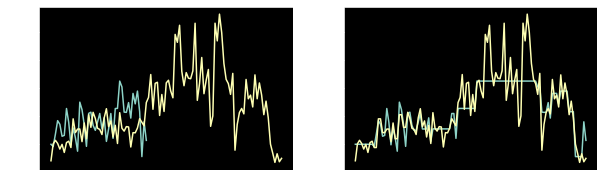

In [3]:
idx0 = 5
idx1 = 2
def plot_dtw(idx0, idx1):
    x0 = np.array(df['X'].iloc[idx0])
    x1 = np.array(df['X'].iloc[idx1])
    distance, path = fastdtw(x0, x1, dist=euclidean)
    path = np.array(path)
    print(distance)

    R, C = 1, 2
    plt.figure(figsize=(10, 3))
    plt.subplot(R, C, 1)
    plt.plot(x0)
    plt.plot(x1)
    plt.subplot(R, C, 2)
    plt.plot(x0[path[:, 0]])
    plt.plot(x1[path[:, 1]])
plot_dtw(idx0, idx1)

# look at closest pairs

100%|██████████| 2936/2936 [00:03<00:00, 884.03it/s] 


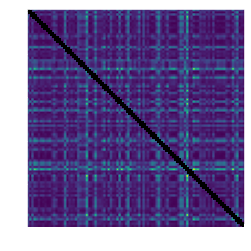

In [5]:
with open(oj(config.DIR_INTERIM, 'dists_dtw.npy'), 'rb') as f:
    dists = np.load(f)
for r in tqdm(range(n)):
    for c in range(r):
        dists[r, c] = dists[c, r]
dists[dists==0] = np.nan
plt.imshow(dists[:100, :100])
plt.show()

In [ ]:
R, C = 6, 10
plt.figure(figsize=(C * 2, R * 2))
lifetimes = df.lifetime.values

# iterate over examples that were aux+
for i, idx0 in enumerate(np.where(y)[0]):
    # find the class of an example

    # distances to every other trace
    d0 = deepcopy(dists[idx0])
    
    # exclude things in the same class
    idxs_same_class = y == 1
    d0[idxs_same_class] = np.nan
    
    # exclude things with very different lifetimes
    idxs_diff_lifetimes = np.abs(lifetimes - lifetimes[idx0]) > 7
    d0[idxs_diff_lifetimes] = np.nan
    idx1 = np.nanargmin(d0)

    x0 = np.array(df['X'].iloc[idx0])
    x1 = np.array(df['X'].iloc[idx1])
    plt.subplot(R, C, i + 1)
    plt.plot(x0, color=cr, label='aux+')
    plt.plot(x1, color='pink', label='aux-')
    plt.ylim((0, 4000))
    plt.xlim((0, 50))
    plt.axis('off')
    
    if i == R * C - 1:
        plt.tight_layout()
        plt.legend(fontsize=15)
        break